# Based on variance

In [55]:
# from sklearn.feature_selection import VarianceThreshold
# data = ...
# var_thresh = VarianceThreshold(threshold=0.1)
# transformed_data = var_thresh.fit_transform(data)
# # transformed data will have columns with >=0.1 variance


# Based on correlation

In [56]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# convert to pandas dataframe
df = pd.DataFrame(X, columns=col_names)
# introduce a highly correlated column
df.loc[:, "MedInc_sqrt"] = df.MedInc.apply(np.sqrt)

df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc_sqrt
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.984329
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,-0.132797
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.326688
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.066910
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,0.018415
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,0.015266
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.084303
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.015569
MedInc_sqrt,0.984329,-0.132797,0.326688,-0.066910,0.018415,0.015266,-0.084303,-0.015569,1.000000


# Univariate feature selection (UFS)

- Univariate feature selection is nothing but a scoring of each feature against a given target

- ANOVA, F-test, chi^2 are some of the popular methods for doing univariate feature selection

- There are two ways of using these in sklearn:
    
    - SelectKBest: It keeps the top k-scoring features
    - SelectPercentile: It keeps the top features which are in a percentage specified by the user

## UFS Wrapper for any problem

In [57]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile


class UnivariateFeatureSelection:
    def __init__(self, n_features, problem_type, scoring):
        """
        Custom univariate feature selection wrapper on different univariate
            feature selection models from sklearn
        :param n_features: SelectPercentile if float else SelectKBest
        :param problem_type: classification or regression
        :param scoring: scoring function, string
        """
        
        # for a given problem type, there are only a few valid scoring methods
        # extend this with your own custom methods if required
        if problem_type == "classification":
            valid_scoring = {"f_classif": f_classif,
                            "chi2": chi2,
                            "mutual_info_classif": mutual_info_classif}
        else:
            valid_scoring = {"f_regression": f_regression,
                            "mutual_info_regression": mutual_info_regression}
        
        # raise exception if there is no valid scoring method:
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")
            
        # if n_features in int, we select KBest
        # if n_features is float, we select SelectPercentile
        # please note that it is int in both cases in sklearn
        if isinstance(n_features, int):
            self.selection = SelectKBest(valid_scoring[scoring], k=n_features)
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(valid_scoring[scoring], percentile=int(n_features * 100))
        else:
            raise Exception("Invalid type of feature")
        
    # same fit function
    def fit(self, X, y):
        return self.selection.fit(X,y)

    # same transform function

    def transform(self, X):
        return self.selection.transform(X)

    # same fit transform function
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)

from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

ufs = UnivariateFeatureSelection(n_features=0.2, problem_type="regression", scoring="f_regression")
ufs.fit(X, y)
X_transformed = ufs.transform(X)
# X_transformed
X_transformed.shape   

(20640, 2)

# Feature Selection using ML model

## Greedy Feature Selection (GFS)


- The simplest form of feature selection that uses a model for selection is known as "Greedy feature selection"

- In GFS, steps:

    - the first step is to choose the model

    - the second step is to select a loss/scoring function
    
    - the third and final step is to iteratively evaluate each feature and add it to a list of "good" features if it improves loss/score
    
**Note**:

    - The feature selection process will fit a given model each time it evaluates a feature (reason, known as GFS)
    
    - The computational cost associated with GFS is very high and will take a lot of time for this kind of feature selection to finish
    
    - if we don't use this feature selection properly, we might end up overfitting the model
    

In [54]:
# greedy.py

import pandas as pd
from sklearn import metrics
from sklearn import linear_model
from sklearn.datasets import make_classification

class GreedyFeatureSelection:
    """
    A simple and custom class for greedy feature selection
    Can be customized for other type of problems
    """
    
    def evaluate_score(self, X, y):
        """
        This function evaluates model on data and returns AUC
        NOTE: we fit the data and calculate AUC on same data
        WE ARE OVERFITTING HERE
        But this is also a way to achieve greedy selection.
        k-fold will take k times longer
        
        To implement the correct way, calculate OOF AUC and return mean AUC over k folds
        :param X: training data
        :param y: targets
        :return: overfitted  area under the roc curve
        """
        # fit the logistic regression model and calculate AUC on same data
        # choose any model that suits the data
        model = linear_model.LogisticRegression()
        model.fit(X, y)
        predictions = model.predict_proba(X)[:, 1]
        auc = metrics.roc_auc_score(y, predictions)
        return auc
    
    
    def _feature_selection(self, X, y):
        """
        This function does the actual greedy selection
        :param X: data, numpy array
        :param y: targets, numpy array
        :return: (best scores, best features)
        """
        
        # initialize good features list and best features to keep track of both
        good_features = []
        best_scores = []
        
        # calculate the number of features
        num_features = X.shape[1]
        
        # infinite loop
        while True:
            # initialize best feature and score of this loop
            this_feature = None
            best_score = 0
            
            # loop all features
            for feature in range(num_features):
                # if feature is already in good features, skip this for loop
                if feature in good_features:
                    continue
                
                # selected features are all good features and current feature
                selected_features = good_features + [feature]
                
                # remove all other features from data
                xtrain = X[:, selected_features]
                
                # calculate the score in our case AUC
                score = self.evaluate_score(xtrain, y)
                
                # if score is greater than best_score of this loop, change best score and best feature
                if score > best_score:
                    this_feature = feature
                    best_score = score
                
                # if we have selected a feature, add it to feature list and update best scores list
                if this_feature!=None:
                    good_features.append(this_feature)
                    best_scores.append(best_score)
                    
                    
                # if we didnt improvr during the previous round, exit the while loop
                if len(best_scores)>2:
                    if best_scores[-1] < best_scores[-2]:
                        break
                        
        return best_scores[:-1], good_features[:-1]
    
    def __call__(self, X, y):
        """
        call function will the class on a set of arguments
        """
        # select features, return scores and selected indices
        scores, features = self._feature_selection(X, y)
        # transformed data with selected features
        return X[:, features], scores
    
    
if __name__ == "__main__":
    # generate binary classification data
    X, y = make_classification(n_samples=1000, n_features=4)
    print(f"Original Shape --> {X.shape}")
    # transform data by greedy feature selection
    X_transformed, scores = GreedyFeatureSelection()(X, y)
    print(f"Transformed Shape --> {X_transformed.shape}")
    # transform data by greedy feature selection
    X_transformed, scores = GreedyFeatureSelection()(X, y)
         

## Recursive Feature Elimination (RFE)

- Another greedy approach is RFE
- In RFE, we start with all features and keep removing one feature in very iteration that provides the least value to a given model
- When we are doing recursive feature elimination, in each iteration, we remove the feature which has the feature importance or the feature which has a coefficient close to 0

In [59]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

# fetch a regression dataset
data = fetch_california_housing()
X = data["data"]
print(X.shape)
col_names = data["feature_names"]
Y = data["target"]

# initialize the model 
model = LinearRegression()
# initialize RFE
rfe = RFE(estimator=model, n_features_to_select=3)

# fit RFE
rfe.fit(X, y)

# get the transformed data with selected columns
X_transformed = rfe.transform(X)
print(X_transformed.shape)


(20640, 8)
(20640, 3)


# Feature importance using Random Forest Model

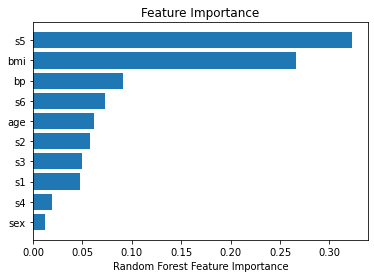

In [62]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# fetch data
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = RandomForestRegressor()
model.fit(X, y)

# feature importance from random forest model
importances = model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importance')
plt.barh(range(len(idxs)), importances[idxs], align ='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel("Random Forest Feature Importance")
plt.show()
         

# SelectFromModel class

- Scikit-learn also offers SelectFromModel class that helps you choose features directly from a given model


In [63]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# fetch regression dataset
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = RandomForestRegressor()

# select from model
sfm = SelectFromModel(estimator=model)
X_transformed = sfm.fit_transform(X, y)

# see which features are selected
support = sfm.get_support()

# get feature names
print([x for x, y in zip(col_names, support) if y ==True])

['bmi', 's5']
